# Homework 5

In this homework, you'll review some linear algebra, and practice using `scipy.optimize` to solve several variations of linear models.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but in our discussion (and codes) we will replace $\beta$ with `b`
```
y = X * b + eps.
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features (so it is an $n\times p$ matrix).  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  One way to do this is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (37 points)

There are a variety of ways to solve the above problem.  We will assume that $n > p$, meaning there are more observations than features.

### Part A: Generating Data (5 points)

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well. 


In [2]:
'''
    Function to generate a linear least squares problem.
    
    Parameters:
    n : Number of observations (rows in X).
    p : Number of features (columns in X).
    sig (float): Standard deviation of the noise applied to y.
    
    Returns:
    X : The design matrix.
    y : The response vector.
    b : The ground truth coefficients.
'''
def gen_lstsq(n, p, sig = 0.1):
    # Create a 'n' by 'p' random feature matrix 'X' with standard normal distributed values
    X = np.random.randn(n, p)
    # Creat a random coefficient vector 'b' with 'p' elements
    b = np.random.randn(p)
    # The response variable 'y' is calculated as the dot product of 'X' and 'b' plus the random noise
    y = X @ b + sig * np.random.randn(n)
    return X, y, b

### Part B: QR factorization (3 points)

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above. 

In [3]:
'''
    Estimates the coefficients b using the QR factorization.

    Parameters:
    X : The design matrix.
    y : The response vector.

    Returns:
    b : The estimated coefficients.
'''
def solve_lstsq_qr(X, y):
    # Perform QR factorization
    Q, R = la.qr(X, mode = 'economic')
    # Solve the upper triangular system R * b = Q transpose * y
    b = la.solve(R, np.dot(Q.T, y))
    return b


### Part C: Normal Equations (3 points)

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above. Note that forming the full inverse would be slow and unstable. Instead, you should try to apply $(X^TX)^{-1}$ by forming a Cholesky factorization instead.

In [4]:
'''
    Uses Cholesky factorization to solve the linear least squares normal equations.

    Parameters:
    X : Design matrix of shape.
    y : Response vector of shape.

    Returns:
    b : Estimated coefficients of shape.
'''
def solve_lstsq_normal(X, y):
    #Perform Cholesky decomposition on X^T * X
    chol_Matrix = la.cholesky(X.transpose() @ X)
    # Solve chol_Matrix * M` = X^T * y for M
    M = la.solve(chol_Matrix.transpose(), X.transpose() @ y)
    # Solve chol_Matrix * b = M for b
    b = la.solve(chol_Matrix, M)
    return b

### Part D: Check Your Work (3 points)

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [5]:
# List of features and observation counts to be tested
nList = [10,20,30]
pList = [3, 5, 7]
# Generate random issues and solve them by looping over every combination of n and p
for n in nList:
    for p in pList:
        X = np.random.randn(n, p)
        y = np.random.randn(n)
        # Use a custom QR factorization and Normal approach to solve the problem
        b_qr = solve_lstsq_qr(X, y)
        b_normal = solve_lstsq_normal(X, y)
        # Solve using NumPy's lstsq
        b_numpy, res, rnk, s = la.lstsq(X, y)
        # Calculate the differences
        qr_normal = la.norm(b_qr - b_normal)
        qr_numpy = la.norm(b_qr - b_numpy)
        normal_numpy = la.norm(b_normal - b_numpy)
        # Check to see if the differences are small enough
        # If it is less than 1e-4, print the result; otherwise, print an error message
        print("||b_qr - b_normal||_2:", qr_normal)
        print("||b_qr - b_numpy||_2:", qr_numpy)
        print("||b_normal - b_numpy||_2:", normal_numpy)
        assert qr_normal < 1e-4, "QR and Normal not small enough"
        assert qr_numpy < 1e-4, "QR and NumPy.lstsq not small enough"
        assert normal_numpy < 1e-4, "Normal and NumPy.lstsq not small enough"

||b_qr - b_normal||_2: 2.6766507790745728e-16
||b_qr - b_numpy||_2: 1.2412670766236366e-16
||b_normal - b_numpy||_2: 3.5217877337871735e-16
||b_qr - b_normal||_2: 4.4147945634195518e-16
||b_qr - b_numpy||_2: 3.3766115072321297e-16
||b_normal - b_numpy||_2: 4.783309287441108e-16
||b_qr - b_normal||_2: 7.654515251348101e-16
||b_qr - b_numpy||_2: 1.016044584868286e-15
||b_normal - b_numpy||_2: 1.4187959606206734e-15
||b_qr - b_normal||_2: 8.441528768080323e-17
||b_qr - b_numpy||_2: 2.0630814761166832e-16
||b_normal - b_numpy||_2: 2.6184557666721356e-16
||b_qr - b_normal||_2: 8.429042611985086e-17
||b_qr - b_numpy||_2: 6.266651041207814e-17
||b_normal - b_numpy||_2: 6.283435673255384e-17
||b_qr - b_normal||_2: 1.9329521701561158e-16
||b_qr - b_numpy||_2: 5.181453794521192e-16
||b_normal - b_numpy||_2: 5.969062235490921e-16
||b_qr - b_normal||_2: 1.1857187100668868e-16
||b_qr - b_numpy||_2: 3.115555635791418e-16
||b_normal - b_numpy||_2: 3.4915808093142e-16
||b_qr - b_normal||_2: 1.95554970

Solve_lstsq_qr and solve_lstsq_normal did not produce identical predictions, but the difference between their predictions is significantly smaller than 1e-4.


### Part E: Estimate the Error (6 points)

Write a function `err` which estimates the error in your fit using the equation $\frac{1}{n}\|X * \hat{b} - y\|_2^2$. The function should have the call signature `err(X,y,bhat).` 

Create a plot of the error vs the noise parameter `sig` (i.e. use your code from the previous parts to generate $y,$ $\hat{b},$ and $X$ for various $\sigma \in[10^{-4},10]$ and use `err` to compute the corresponding error).  Use `n=100`, `p=50` when generating data.  Put your plot on log-log axes.  Give it a title and axis labels.

As above, you should generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)`. Note: when choosing `sig` on $[10^{-4},10]$ it would help if you gave them a logarithmic distribution (like taking equispaced points $t_0,\dots,t_N$ between -4 and 1, and setting $\sigma_0 =10^{t_0},\dots, \sigma_N = 10^{t_n}.$

Try to make smoother plots by averaging the error over several trials.


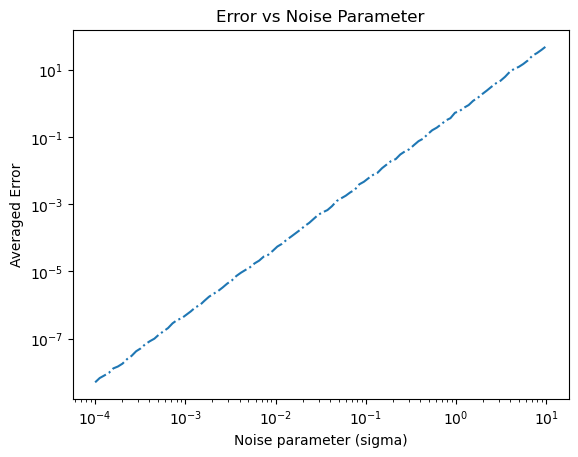

In [39]:
import numpy as np
'''
    Uses the mean squared error formula to estimate the fit error.

    Parameters:
    X : Design matrix of shape.
    y : Response vector of shape.
    bhat : Estimated coefficients of shape.

    Returns:
    error : The mean squared error of the fit.
'''
def err(X, y, bhat):
    # Compute the error
    error = (1 / len(y)) * la.norm(X @ bhat - y)**2
    return error

n, p = 100, 50
# Uses numpy's logspace function to generate an array of 100 values logarithmically spaced between 10^-4 and 10^1
sigmas = np.logspace(-4, 1, 100)
# Initialize a list to collect the mean errors for different sigma value
errors = []
# Create a for loop to iterate over each sigma value in the 'sigmas' array
for sigma in sigmas:
    #Create a list to collect errors from several trials for the current sigma value
    temp_errors = []
    # Perform 20 trials to average the error
    for _ in range(20):
        X = np.random.randn(n, p)
        b = np.random.randn(p)
        y = X @ b + sigma * np.random.randn(n)
        b_qr = solve_lstsq_qr(X, y)
        temp_errors.append(err(X, y, b_qr))
    # Append the sigmas' average error to errors
    errors.append(np.mean(temp_errors))
# Plot the averaged errors
plt.loglog(sigmas, errors,linestyle='-.')
plt.title('Error vs Noise Parameter')
plt.xlabel('Noise parameter (sigma)')
plt.ylabel('Averaged Error')
plt.show()


The plot clearly demonstrates a trend whereby the error rises with an increase in the noise parameter (sigma). This implies that the accuracy of the linear regression model's fit to the data declines with increasing noise in the data, resulting in increased errors. The linear trend on the log-log plot suggests that the relationship is logarithmic.

### Part F: Discussion (10 points)

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations as a function of $n$ and $p$).

Suppose that $\kappa(X)$ is large. Which of `solve_lstsq_qr` and `solve_lstsq_normal` will be more stable? i.e. which of $\hat{b} = R^{-1} Q^T y$ and $\hat{b} = (X^T X)^{-1} X^T y$ has a smaller condition number? Use the fact that the matrix condition number satisfies
$$
\kappa(A^{-1}) = \kappa(A), \qquad \kappa(A^T) = \kappa(A), \qquad \kappa(AB) \approx \kappa(A)\kappa(B),
$$
and that
$$
\kappa(Q) = 1
$$
because the columns of $Q$ are orthonormal. You should also use the fact that for most $A$ and $B$
$$
\kappa(AB) \approx \kappa(A)\kappa(B).
$$
Note that there are counter examples, e.g. $1=\kappa(I)=\kappa(AA^{-1})< \kappa(A)\kappa(A^{-1})=\kappa(A)^2$ whenever $\kappa(A)>1$.

In [44]:
import time
# List of features and observation counts to be tested
nList = [200,400,500]
pList = [50, 80, 90]
# Generate random issues and solve them by looping over every combination of n and p
for n in nList:
    for p in pList:
        X = np.random.randn(n, p)
        y = np.random.randn(n)
        # Measure the time it takes to solve the least squares problem using QR decomposition and normal equations
        start = time.time()
        b_qr = solve_lstsq_qr(X, y)
        qr_time = time.time() - start
        start = time.time()
        b_normal = solve_lstsq_normal(X, y)
        normal_time = time.time() - start
        print("QR function spent time:", qr_time)
        print("Normal function spent time:", normal_time)
        if normal_time < qr_time:
            print('Normal function is faster.')
        else:
            print('QR function is faster.')

QR function spent time: 0.09806275367736816
Normal function spent time: 0.0003859996795654297
Normal function is faster.
QR function spent time: 0.0009469985961914062
Normal function spent time: 0.0004429817199707031
Normal function is faster.
QR function spent time: 0.0010709762573242188
Normal function spent time: 0.00044918060302734375
Normal function is faster.
QR function spent time: 0.001220703125
Normal function spent time: 0.00022125244140625
Normal function is faster.
QR function spent time: 0.0012242794036865234
Normal function spent time: 0.0004298686981201172
Normal function is faster.
QR function spent time: 0.0036830902099609375
Normal function spent time: 0.0011599063873291016
Normal function is faster.
QR function spent time: 0.002161741256713867
Normal function spent time: 0.0002701282501220703
Normal function is faster.
QR function spent time: 0.005316734313964844
Normal function spent time: 0.0005309581756591797
Normal function is faster.
QR function spent time: 0.00

Solve_lstsq_normal method is faster. Cholesky decomposition is tailored for symmetric positive definite matrices. This specialization allows it to be more efficient. In comparison to QR decomposition, it necessitates fewer operations, particularly for big matrices. While Cholesky works directly on the triangular portion of the matrix, QR involves both orthogonalization and triangularization. A crucial stage in Cholesky decomposition is solving triangular systems, which is less complicated and computationally efficient than matrix factorizations in QR decomposition. Cholesky decomposition has less overhead, making it more efficient for smaller problem sizes. QR is generally renowned for its stability, but for well-conditioned matrices, it may be more numerically stable. Cholesky makes complete use of the matrix's structure and is tailored and optimized for positive definite matrices.

Solve_lstsq_qr method is more stable since its condition number of mapping from y to b is smaller. For 𝑏̂ =𝑅^−1𝑄^𝑇𝑦, the condition number of mapping from y to b equals 𝜅(R^-1)𝜅(Q^T) = 𝜅(R)𝜅(Q) ≈ 𝜅(RQ) = 𝜅(X). For 𝑏̂ =(𝑋^𝑇𝑋)^−1𝑋^𝑇𝑦, the condition number of mapping from y to b equals 𝜅((𝑋^𝑇𝑋)^−1))𝜅(X^T) = 𝜅(𝑋^𝑇𝑋)𝜅(X) ≈ 𝜅(𝑋^𝑇)𝜅(X)𝜅(X) = 𝜅(X)𝜅(X)𝜅(X) ≈ 𝜅(X^3). According to our assumption, 𝜅(X) is large, and condition number is always greater than 0, it follows that 𝜅(X^3) is greater than 𝜅(X). 

### Part G: Optimization (5 points)

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [18]:
'''
    Calculate the difference between the observed and expected y values from X @ b using the least squares method.

    Parameters:
    b : The parameter vector for which we want to compute the least squares.
    X : The design matrix containing the independent variables of our model.
    y : The observed response vector.

    Returns:
    float: The computed least square error.
'''
def least_square(b, X, y):
    # Compute the least squares error
    return (1 / len(y)) * la.norm(X @ b - y)**2

'''
    Compute the Jacobian of the least squares objective function.

    Parameters:
    b : The parameter vector for which we want to compute the Jacobian.
    X : The design matrix containing the independent variables of our model.
    y : The observed response vector.

    Returns: The Jacobian vector.
'''
def Jacobian(b, X, y):
    # Compute the Jacobian of the objective function
    return (2 / len(y)) * (X.T @ X @ b - y.transpose() @ X)

'''
    Utilizing the BFGS approach, minimize the least squares goal function to solve the least squares problem.

    Parameters:
    X : The design matrix containing the independent variables of our model.
    y : The observed response vector.

    Returns: The optimized parameter vector.
'''
def solve_lstsq_opt(X, y):
    init_guess = np.zeros(X.shape[1])
    # Call minimize from scipy.optimize
    result = scipy.optimize.minimize(fun = least_square, x0 = init_guess, \
        args = (X, y),jac = Jacobian, method = 'BFGS')
    return result.x


#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [41]:
# List of features and observation counts to be tested
nList = [10,20,30]
pList = [5,3]
# Generate random issues and solve them by looping over every combination of n and p
for n in nList:
    for p in pList:
        X = np.random.randn(n, p)
        y = np.random.randn(n)
        # Solve the least squares problem using QR, normal, and optimization method
        b_qr = solve_lstsq_qr(X, y)
        b_normal = solve_lstsq_normal(X, y)
        b_opt = solve_lstsq_opt(X, y)
        # Calculate the norm difference between the solutions
        qr_opt = la.norm(b_qr - b_opt)
        normal_opt = la.norm(b_normal - b_opt)
        print("||b_qr - b_opt||_2:", qr_opt)
        print("||b_normal - b_opt||_2:", normal_opt)
        # Assertions to check that the differences are small enough
        assert qr_opt < 1e-4, "QR and opt not small enough"
        assert normal_opt < 1e-4, "Normal and opt not small enough"

||b_qr - b_opt||_2: 1.7476457798392186e-06
||b_normal - b_opt||_2: 1.7476457798146034e-06
||b_qr - b_opt||_2: 9.287605789528418e-07
||b_normal - b_opt||_2: 9.287605788848778e-07
||b_qr - b_opt||_2: 5.648416854468436e-06
||b_normal - b_opt||_2: 5.64841685446113e-06
||b_qr - b_opt||_2: 3.046689421649539e-07
||b_normal - b_opt||_2: 3.0466894218483166e-07
||b_qr - b_opt||_2: 5.6228056270633834e-06
||b_normal - b_opt||_2: 5.6228056270649005e-06
||b_qr - b_opt||_2: 1.0643082340824664e-06
||b_normal - b_opt||_2: 1.064308234052569e-06


Solve_lstsq_opt agrees with solve_lstsq_qr and solve_lstsq_normal. The norm of the differences between the solution vectors obtained from the optimization method and the other two methods are all significantly smaller than the threshold of 1e-4. This suggests that the solutions are highly comparable, which is often regarded as agreement in the context of numerical techniques and floating-point computations.

### Part H: Discussion (2 points)

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [29]:
import time
n, p = 200, 20
X, y, b = gen_lstsq(n, p)
# Utilizing an optimization-based approach, solve the least squares problem and record the time required
start_time = time.time()
b_opt = solve_lstsq_opt(X, y)
opt_time = time.time() - start_time
print("Time use for solve_lstsq_opt:", opt_time)
# Utilizing QR decomposition, solve the least squares problem and record the time required
start_time = time.time()
b = solve_lstsq_qr(X, y)
end = time.time() - start_time
print("Time use for solve_lstsq_qr:", end)
# Utilizing the normal equation, solve the least squares problem and record the time required
start_time = time.time()
b = solve_lstsq_normal(X, y)
end = time.time() - start_time
print("Time use for solve_lstsq_normal:", end)

Time use for solve_lstsq_opt: 0.017575979232788086
Time use for solve_lstsq_qr: 0.0008709430694580078
Time use for solve_lstsq_normal: 0.00014495849609375


The solve_lstsq_normal method is the fastest because it's specialized for symmetric positive definite matrices, like X^TX. It requires fewer operations, making it computationally efficient. For matrices that are well-conditioned, it is numerically stable. It concerns the computationally efficient solution of triangular systems. When compared to QR decomposition, it has reduced overhead. The optimization method is slower because it relies on iterative numerical optimization, which requires multiple iterations and can be computationally expensive. The QR method is slower due to the orthogonalization and triangularization steps involved, which can be more computationally intensive than the Cholesky decomposition method's direct triangular solves.
The solve_lstsq_normal method is the fastest, followed by the solve_lstsq_qr, and lastly, the solve_lstsq_opt.



## Problem 1 - Ridge Regression (13 points)

We'll now turn to the problem of what to do when `n < p` (there are now fewer observations than features).  In this case we can find a $b$ which satisfies the equation $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

As we discussed in class, we can change the problem to try to make it unique. One simple way of doing this is to add an additional term to our optimization problem. Ridge regression is one such approach.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Part A: Optimization (9 points)

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---


In [31]:
'''
    Utilizes Scipy's minimize function to find a solution to the Ridge Regression Optimization Problem.

    Parameters:
    X : The input matrix where each row is a sample and each column is a feature.
    y : The target vector where each element corresponds to a sample in X.
    lam : The regularization parameter which controls the strength of the shrinkage
    applied to the coefficients (default is 0.1).

    Returns: The coefficient vector that minimizes the objective function.
'''
def solve_ridge_opt(X, y, lam = 0.1):
    n, p = X.shape
    '''
        The objective function for ridge regression to be minimized.
        
        Parameters:
        b : The coefficient vector for which the objective function is calculated.
            
        Returns: Residual sum of squares term plus regularization term
    '''
    def least_square(b):
        return (1/n) * np.sum((X @ b - y)**2) + lam * np.sum(b**2)
    '''
        The Jacobian of the objective function.
        
        Parameters:
        b : The coefficient vector for which the Jacobian is calculated.
            
        Returns: Gradient of the regularization term plus gradient of the residual sum of squares term
    '''
    def Jacobian(b):
        return (2/n) * X.T.dot(X @ b - y) + 2 * lam * b
    
    b_init = np.zeros(p)
    # Perform the optimization using BFGS method
    result = scipy.optimize.minimize(fun = least_square, x0 = b_init, jac = Jacobian, method = 'BFGS')
    return result.x


Here is how we calculate the Jacobian regularization term: $\frac{\partial}{\partial b_i}(\lambda\|b\|_2^2) = \lambda\frac{\partial}{\partial b_i}( b^T b) =\lambda\frac{\partial}{\partial b_i} ( \sum b_i^2) = 2\lambda b_i$. As a result, the Jacobian for the optimization issue using ridge regression is:
\begin{equation}
J = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + 2\lambda b 
\end{equation}



### Part B: Compute the error (4 points)

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the error of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2` (see Problem 0, Part E).  Use a `semilogx` plot.

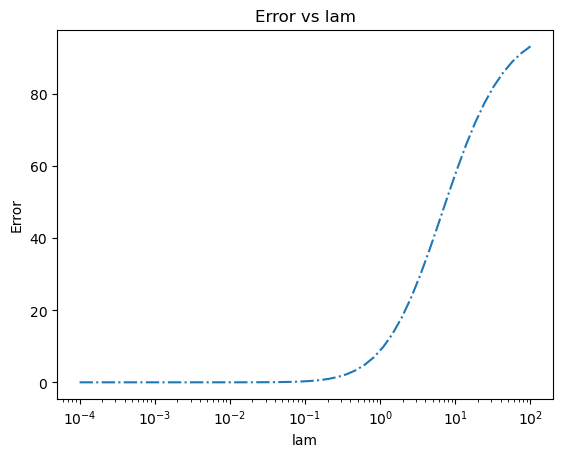

In [46]:
'''
    Calculate the mean squared error of predictions.

    Parameters:
    X :  The input matrix where each row is a sample and each column is a feature.
    y :  The target vector where each element corresponds to a sample in X.
    bhat : The estimated coefficients.

    Returns: The mean squared error.
'''
def err(X, y, bhat):
    error = (1 / len(y)) * np.linalg.norm(X @ bhat - y)**2
    return error
n, p, sig = 50, 100, 0.1
# generates 50 values spaced evenly on a log scale between 10^-4 and 10^2
lams = np.logspace(-4, 2, 50)
# List to store the mean errors for each lambda
errors = []
X = np.random.randn(n, p)
b = np.random.randn(p)
y = X @ b + sig * np.random.randn(n)
# Loop over lambda values
for lam in lams:
    # Temporary list to store mean errors for each run
    temp_errors = []
    for _ in range(10):
        # Solve the ridge regression problem
        b_opt = solve_ridge_opt(X, y, lam)
        # Calculate and store the error
        temp_errors.append(err(X, y, b_opt))
    # Append the mean error for this lambda
    errors.append(np.mean(temp_errors))
# Plot the error vs lambda 
plt.semilogx(lams, errors, linestyle='-.')
plt.title('Error vs lam')
plt.xlabel('lam')
plt.ylabel('Error')
plt.show()

The plot shows that the model error is small when the regularization parameter λ is small, indicating a good fit to the data. The model appears to underfit as λ grows, suggesting that over-regularization penalizes the coefficients excessively, resulting in significant bias. A range of λ values is considered best when it comes to minimizing error before it gets worse. This suggests that a balance between model complexity and generalization is reached in this range.

### Part C: Analysis (optional - no points)

Find an analytic expression for the true solution to the ridge regression problem in terms of $X,$ $\lambda,$ and $y.$

### Part D: SVD (optional - no points)

Use the SVD to solve $X*b = y.$ Do this by forming the SVD of $X = U\Sigma V^T.$ Set $b = V z$ where $V$ is the $p\times n$ matrix consisting of the first $n$ right singular vectors (why?). Then, the system you get is $U \Sigma z = y.$ You can solve it by applying $U^T$ to both sides (why?) and noting that $\Sigma$ is diagonal. 

Note that you should be using the version of the SVD which (for $n<p$ but $X$ having full rank) gives $U$ as an $n\times n$ matrix, $\Sigma$ as an $n\times n$ diagonal matrix, and $V$ as a $p \times n$ matrix.